# Install & Imports

In [1]:
pip install fastf1 pandas numpy scikit-learn matplotlib seaborn joblib requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.0/165.0 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.0/70.0 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 15.0.1
    Uninstalling websockets-15.0.1:
      Successfully uninstalled websockets-15.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.8.3 requires websockets>=14.0, but you have websockets 13.1 which is incompatible.
google-adk 1.13.0 requires websockets<16.0.0,>=15.0.1, but you have websockets 13.1 which is incompatible.


In [24]:
import fastf1
import pandas as pd
import numpy as np
import requests
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib
import json
from datetime import datetime
import os

# Set style for visuals
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Define the Predictor Class

Loading 2024 race data...


core           INFO 	Loading data for Dutch Grand Prix - Race [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for Dutch Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core           IN

Loaded data for 20 drivers
Using simulated weather data for Monza
Model Performance:
MAE: 0.213 seconds
R² Score: 0.794

🏁 Predicted 2025 Italian GP Results 🏁
  Driver          Team  PredictedRaceTime (s)  PredictedPosition
3    NOR       McLaren              75.558324                  1
0    VER      Red Bull              75.894366                  2
1    LEC       Ferrari              75.914995                  3
4    PIA       McLaren              75.918563                  4
2    SAI       Ferrari              75.946225                  5
6    HAM      Mercedes              76.166732                  6
5    RUS      Mercedes              76.174746                  7
9    GAS        Alpine              76.706700                  8
8    ALB      Williams              76.717305                  9
7    ALO  Aston Martin              76.776086                 10


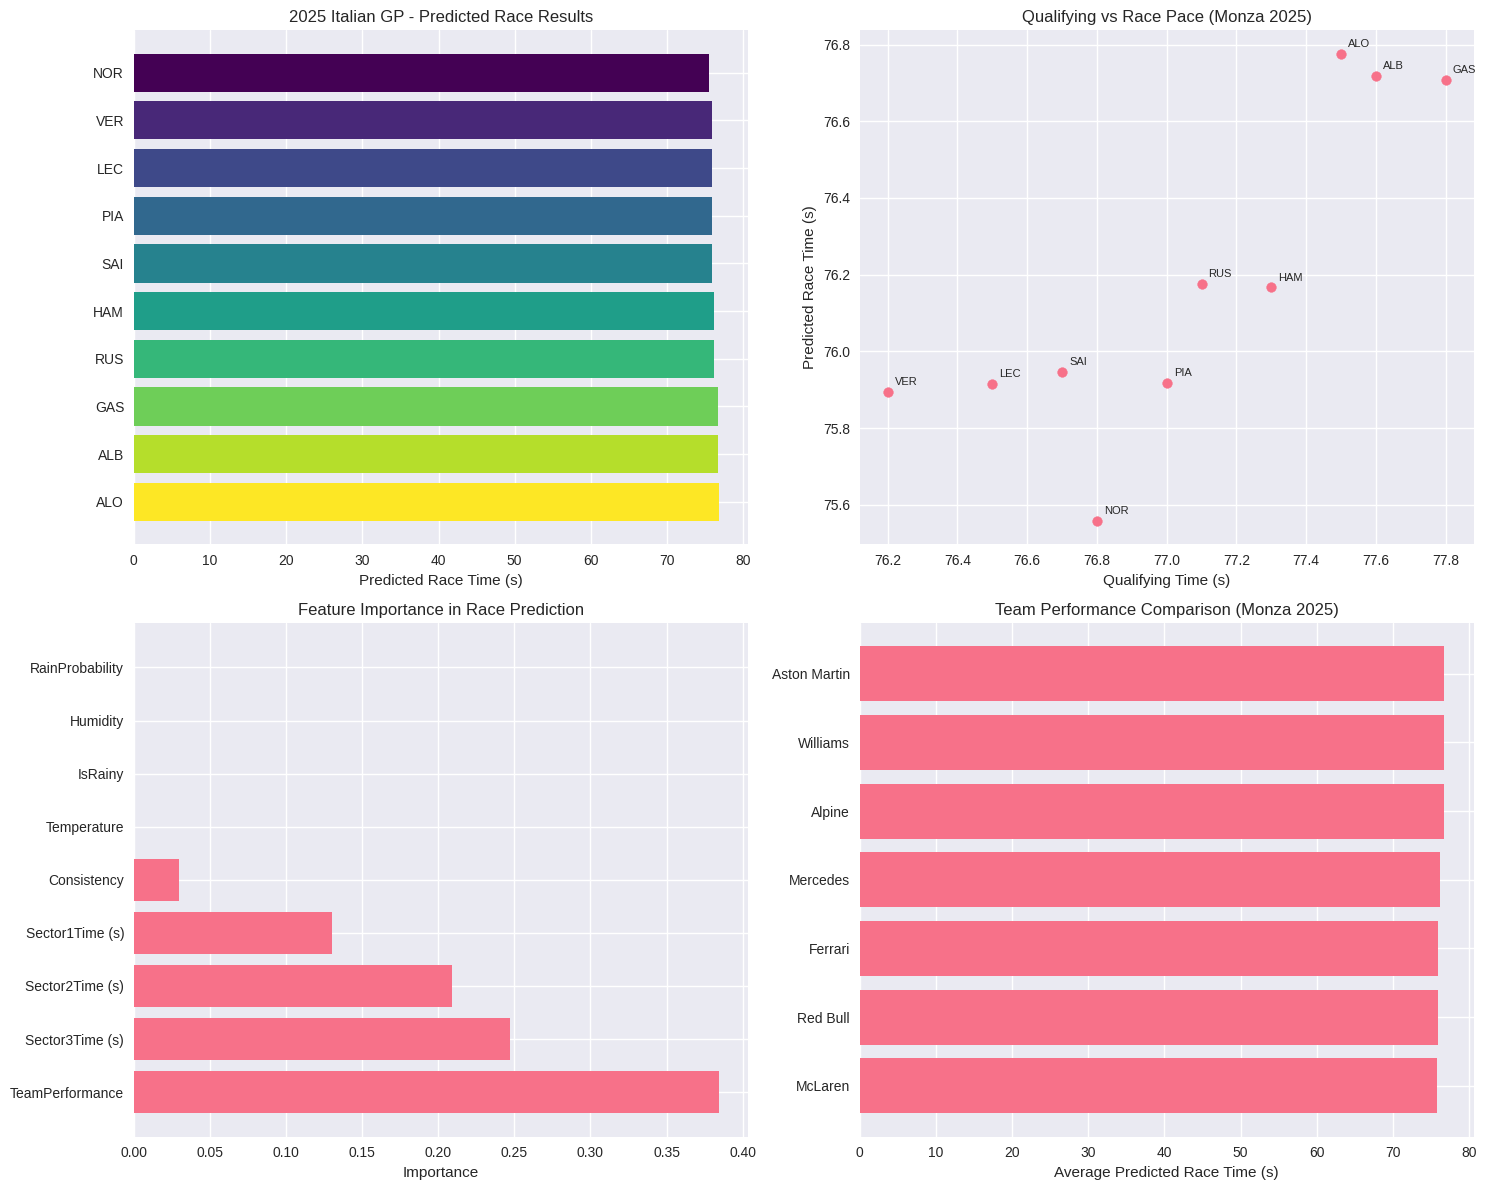

Model saved to monza_2025_predictor_model.pkl


In [25]:
class F1RacePredictor:
    def __init__(self, cache_dir="f1_cache"):
        """Initialize the F1 race predictor"""
        if not os.path.exists(cache_dir):
            os.makedirs(cache_dir)
        fastf1.Cache.enable_cache(cache_dir)
        self.data = None
        self.model = None
        self.feature_importance = None
        self.imputer = SimpleImputer(strategy="mean") # Initialize imputer
        self.scaler = StandardScaler() # Initialize scaler


    def load_historical_data(self, year, race_number, session_type="R"):
        """Load historical race data from FastF1"""
        print(f"Loading {year} race data...")
        session = fastf1.get_session(year, race_number, session_type)
        session.load()

        # Get lap data
        laps = session.laps.copy()
        laps = laps[["Driver", "LapTime", "Sector1Time", "Sector2Time", "Sector3Time",
                     "Compound", "TyreLife", "FreshTyre", "Stint", "TrackStatus", "Position"]]

        # Only use green flag laps
        laps = laps[laps["TrackStatus"] == "1"]
        laps.dropna(subset=["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"], inplace=True)

        # Convert times to seconds
        for col in ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]:
            laps[f"{col} (s)"] = laps[col].dt.total_seconds()

        # Calculate consistency (standard deviation of lap times)
        consistency = laps.groupby("Driver")["LapTime (s)"].std().reset_index()
        consistency.columns = ["Driver", "Consistency"]

        # Get average lap times by driver
        avg_times = laps.groupby("Driver").agg({
            "LapTime (s)": "mean",
            "Sector1Time (s)": "mean",
            "Sector2Time (s)": "mean",
            "Sector3Time (s)": "mean",
            "TyreLife": "mean",
            "Stint": "max",
            "Position": "min"  # Best position achieved
        }).reset_index()

        # Merge with consistency data
        self.historical_data = pd.merge(avg_times, consistency, on="Driver")

        # Add team information
        driver_teams = {}
        for driver in laps["Driver"].unique():
            try:
                driver_teams[driver] = laps[laps["Driver"] == driver].iloc[0]["Team"]
            except:
                driver_teams[driver] = "Unknown"

        self.historical_data["Team"] = self.historical_data["Driver"].map(driver_teams)

        print(f"Loaded data for {len(self.historical_data)} drivers")
        return self.historical_data

    def get_weather_data(self, lat, lon, race_date, api_key=None):
        """Get weather data from OpenWeatherMap API or use simulated data"""

        if api_key is None:
            print("Using simulated weather data for Monza")
            return {
                "temperature": 26.5,  # Warm September day
                "humidity": 65,
                "rain_probability": 0.1,  # Low chance of rain
                "conditions": "Clear"
            }

        try:
            base_url = "http://api.openweathermap.org/data/2.5/forecast"
            params = {
                "lat": lat,
                "lon": lon,
                "appid": api_key,
                "units": "metric"
            }

            response = requests.get(base_url, params=params)
            response.raise_for_status()
            weather_data = response.json()

            # Find forecast closest to race time (typically 15:00 local)
            race_datetime = datetime.strptime(f"{race_date} 15:00:00", "%Y-%m-%d %H:%M:%S")
            closest_forecast = None
            min_time_diff = float('inf')

            if "list" in weather_data:
                for forecast in weather_data["list"]:
                    forecast_datetime = datetime.strptime(forecast["dt_txt"], "%Y-%m-%d %H:%M:%S")
                    time_diff = abs((forecast_datetime - race_datetime).total_seconds())

                    if time_diff < min_time_diff:
                        min_time_diff = time_diff
                        closest_forecast = forecast

            if closest_forecast:
                weather_info = {
                    "temperature": closest_forecast["main"]["temp"],
                    "humidity": closest_forecast["main"]["humidity"],
                    "rain_probability": closest_forecast.get("pop", 0),
                    "conditions": closest_forecast["weather"][0]["main"]
                }
                return weather_info
            else:
                print("No forecast found for the specified date and time.")
                return {
                    "temperature": 26.5,
                    "humidity": 65,
                    "rain_probability": 0.1,
                    "conditions": "Clear"
                }
        except requests.exceptions.RequestException as e:
            print(f"Error fetching weather data: {e}")
            return {
                "temperature": 26.5,
                "humidity": 65,
                "rain_probability": 0.1,
                "conditions": "Clear"
            }
        except KeyError as e:
            print(f"Error parsing weather data: Missing key {e}")
            return {
                "temperature": 26.5,
                "humidity": 65,
                "rain_probability": 0.1,
                "conditions": "Clear"
            }


    def create_features(self, qualifying_data, weather_data, team_performance):
        """Create feature set for prediction"""
        # Start with qualifying data
        features = qualifying_data.copy()

        # Add weather data
        features["Temperature"] = weather_data["temperature"]
        features["Humidity"] = weather_data["humidity"]
        features["RainProbability"] = weather_data["rain_probability"]
        features["IsRainy"] = 1 if weather_data["rain_probability"] > 0.5 else 0

        # Add team performance
        features["TeamPerformance"] = features["Team"].map(team_performance)

        # Merge with historical sector times
        if self.historical_data is not None:
            historical_avgs = self.historical_data.groupby("Driver").agg({
                "Sector1Time (s)": "mean",
                "Sector2Time (s)": "mean",
                "Sector3Time (s)": "mean",
                "Consistency": "mean"
            }).reset_index()

            features = features.merge(historical_avgs, on="Driver", how="left")

        return features

    def train_model(self, features, target, test_size=0.2, random_state=42):
        """Train the prediction model"""
        # Separate features and target
        X = features.drop(["Driver", "Team", "QualifyingTime (s)"], axis=1, errors="ignore")
        y = target

        # Handle missing values and scale features
        X_imputed = self.imputer.fit_transform(X)
        X_scaled = self.scaler.fit_transform(X_imputed)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=test_size, random_state=random_state
        )

        # Train model
        self.model = GradientBoostingRegressor(
            n_estimators=150,
            learning_rate=0.1,
            max_depth=4,
            random_state=random_state
        )

        self.model.fit(X_train, y_train)

        # Evaluate model
        y_pred = self.model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f"Model Performance:")
        print(f"MAE: {mae:.3f} seconds")
        print(f"R² Score: {r2:.3f}")

        # Store feature importance
        self.feature_importance = pd.DataFrame({
            "feature": X.columns,
            "importance": self.model.feature_importances_
        }).sort_values("importance", ascending=False)

        return self.model, mae, r2

    def predict_race(self, features):
        """Predict race results"""
        # Prepare features for prediction
        X = features.drop(["Driver", "Team", "QualifyingTime (s)"], axis=1, errors="ignore")

        # Handle missing values and scale features using the fitted imputer and scaler
        X_imputed = self.imputer.transform(X)
        X_scaled = self.scaler.transform(X_imputed)

        # Make predictions
        predictions = self.model.predict(X_scaled)

        # Create results dataframe
        results = features[["Driver", "Team", "QualifyingTime (s)"]].copy()
        results["PredictedRaceTime (s)"] = predictions
        results = results.sort_values("PredictedRaceTime (s)")
        results["PredictedPosition"] = range(1, len(results) + 1)

        return results

    def visualize_results(self, predictions, historical_data=None):
        """Create visualizations of the results"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Plot 1: Predicted race results
        axes[0, 0].barh(predictions["Driver"], predictions["PredictedRaceTime (s)"],
                       color=plt.cm.viridis(np.linspace(0, 1, len(predictions))))
        axes[0, 0].set_xlabel("Predicted Race Time (s)")
        axes[0, 0].set_title("2025 Italian GP - Predicted Race Results")
        axes[0, 0].invert_yaxis()

        # Plot 2: Qualifying vs Race pace
        axes[0, 1].scatter(predictions["QualifyingTime (s)"], predictions["PredictedRaceTime (s)"])
        for i, driver in enumerate(predictions["Driver"]):
            axes[0, 1].annotate(driver,
                               (predictions["QualifyingTime (s)"].iloc[i],
                                predictions["PredictedRaceTime (s)"].iloc[i]),
                               xytext=(5, 5), textcoords='offset points', fontsize=8)
        axes[0, 1].set_xlabel("Qualifying Time (s)")
        axes[0, 1].set_ylabel("Predicted Race Time (s)")
        axes[0, 1].set_title("Qualifying vs Race Pace (Monza 2025)")

        # Plot 3: Feature importance
        if self.feature_importance is not None:
            axes[1, 0].barh(self.feature_importance["feature"], self.feature_importance["importance"])
            axes[1, 0].set_xlabel("Importance")
            axes[1, 0].set_title("Feature Importance in Race Prediction")

        # Plot 4: Team performance comparison
        team_avg = predictions.groupby("Team")["PredictedRaceTime (s)"].mean().sort_values()
        axes[1, 1].barh(team_avg.index, team_avg.values)
        axes[1, 1].set_xlabel("Average Predicted Race Time (s)")
        axes[1, 1].set_title("Team Performance Comparison (Monza 2025)")

        plt.tight_layout()
        plt.savefig("monza_2025_prediction_results.png", dpi=300, bbox_inches="tight")
        plt.show()

    def save_model(self, filepath):
        """Save the trained model to file"""
        joblib.dump(self.model, filepath)
        print(f"Model saved to {filepath}")

    def load_model(self, filepath):
        """Load a trained model from file"""
        self.model = joblib.load(filepath)
        print(f"Model loaded from {filepath}")

# Example usage for 2025 Italian GP
if __name__ == "__main__":
    # Initialize predictor
    predictor = F1RacePredictor()

    # Load historical data (2024 Italian GP for training)
    # For now, we'll assume it was round 15 of the 2024 season
    historical_data = predictor.load_historical_data(2024, 15, "R")

    # Define team performance scores (based on 2024 constructor standings)
    # These would be updated with real 2024 data when available
    team_performance = {
        "Red Bull": 0.95,
        "Ferrari": 0.90,
        "McLaren": 0.87,
        "Mercedes": 0.85,
        "Aston Martin": 0.78,
        "Alpine": 0.72,
        "Williams": 0.70,
        "RB": 0.65,
        "Kick Sauber": 0.62,
        "Haas": 0.60
    }

    # Simulated qualifying data for 2025 Italian GP
    # Monza is the "Temple of Speed" with very low downforce
    qualifying_data = pd.DataFrame({
        "Driver": ["VER", "LEC", "SAI", "NOR", "PIA", "RUS", "HAM", "ALO", "ALB", "GAS"],
        "Team": ["Red Bull", "Ferrari", "Ferrari", "McLaren", "McLaren",
                "Mercedes", "Mercedes", "Aston Martin", "Williams", "Alpine"],
        "QualifyingTime (s)": [76.2, 76.5, 76.7, 76.8, 77.0, 77.1, 77.3, 77.5, 77.6, 77.8]
    })

    # Get weather data for Monza, Italy (September 7, 2025)
    weather_data = predictor.get_weather_data(45.6156, 9.2814, "2025-09-07")

    # Create features for prediction
    features = predictor.create_features(qualifying_data, weather_data, team_performance)

    # Align target data with features
    target_drivers = features["Driver"].tolist()
    target_data = historical_data[historical_data["Driver"].isin(target_drivers)].set_index("Driver").loc[target_drivers]["LapTime (s)"]
    target = target_data.reset_index(drop=True)


    # Train the model
    model, mae, r2 = predictor.train_model(features, target)

    # Make predictions
    predictions = predictor.predict_race(features)

    # Display results
    print("\n🏁 Predicted 2025 Italian GP Results 🏁")
    print(predictions[["Driver", "Team", "PredictedRaceTime (s)", "PredictedPosition"]])

    # Visualize results
    predictor.visualize_results(predictions, historical_data)

    # Save model for future use
    predictor.save_model("monza_2025_predictor_model.pkl")